In [1]:
import numpy as np
import pickle
import os.path
from os.path import isfile, join
from os import path,listdir
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.patches as patches
from pathlib import Path
from tifffile import imread, imsave
!pip install roifile
import roifile

In [13]:
dfOverF = False
Normalize = True

In [14]:
DropboxPath = "/Users/danielbarabasi/Dropbox/Tricaine_Fish_Data/"

## Spot Tricaine

In [18]:
from scipy.interpolate import interp1d
from torch import normal

BasePath_1 =  DropboxPath+ "Spot_Tricaine/"

All_Manys_OnOff = {}
All_Manys_LR = {}
All_Many_Responsiveness = {}

max_positive = 0
min_negative = 0

for Fish in [d for d in os.listdir(BasePath_1) if os.path.isdir(BasePath_1+d)]:
    BasePath = BasePath_1 + Fish + '/'
    files = [i for i in os.listdir(BasePath) if "2022" in i]
    files.sort()
    Manys_LR = np.empty((len(files)*23,0))
    Manys_OnOff = np.empty((len(files)*23,0))
    Many_Responsiveness = np.empty((len(files)*46,0))
    print(BasePath)
    for locNames in ['LR_measurements.csv','OnOff_measurements.csv']: #
        fileLoc = BasePath +"Sept/"+ locNames
        df = pd.read_csv(fileLoc)

        regs = {}

        for regional_traces in range(1,int((len(df.columns)-1)/4)):
            s = list(df['Mean'+str(regional_traces)])
            vals_left = []
            vals_right = []
            vals_responsive = []
            #plt.figure()
            for i,file in enumerate(files):
                vals_left_mean = np.empty((160,0))
                vals_right_mean = np.empty((160,0))
                #plt.subplot(len(files),1,i+1)
                visual_stimulus_data = np.load(BasePath + file + '/rawdata/z_plane0000_trial000_stimulus_data.npz')
                r = np.load(BasePath + file + '/rawdata/z_plane0000_trial000_imaging_information.npy')
                imaging_time = r[:,0]
                f_imaging_interpolation_function_C = interp1d(imaging_time, s[i*2936:(i+1)*2936], bounds_error=False)
                for stimulus_start_time, stim in zip(visual_stimulus_data["stimulus_start_times"][1:],
                                                        visual_stimulus_data["stimulus_start_indices"][1:]):
                    # create a new time array that is 80 seconds and separated at 0.5 sec. i.e. 2 Hz sampling rate
                    # -> Armin did this to scale all imaging data to 2Hz sampling rate...
                    ts = np.arange(stimulus_start_time -10, stimulus_start_time +70 - 0.25, 0.5) # -0.25 is to get exactly 160 samples

                    stimulus_aligned_C = f_imaging_interpolation_function_C(ts)  ## !
                    if dfOverF is True:
                        regions = np.expand_dims((stimulus_aligned_C-np.mean(stimulus_aligned_C[:40]))/np.mean(stimulus_aligned_C[:40]),1)
                    else:
                        regions = np.expand_dims(stimulus_aligned_C-np.mean(stimulus_aligned_C[:40]),1)
                    if (stim == 0) & (vals_left_mean.shape[1] < 23):
                        vals_left_mean = np.append(vals_left_mean,regions,axis = 1)
                        vals_responsive.append(np.mean(regions[40:100]))
                        vals_left.append(np.mean(regions[40:100]))
                    elif (stim == 1) & (vals_right_mean.shape[1] < 23):
                        vals_right_mean = np.append(vals_right_mean,regions,axis = 1)
                        vals_responsive.append(np.mean(regions[40:100]))
                        vals_right.append(np.mean(regions[40:100]))

            #regs['Mean'+str(regional_traces)] = np.array(vals_right)-np.array(vals_left)
            to_append = np.array(vals_right)-np.array(vals_left)
            if Normalize:
                max_positive = max(max_positive,max(vals_responsive))
                min_negative = max(min_negative,abs(min(vals_responsive)))
                Manys_LR = np.append(Manys_LR,np.expand_dims(to_append/np.max(np.abs(to_append)),axis=1),axis = 1)
                Many_Responsiveness = np.append(Many_Responsiveness,np.expand_dims(vals_responsive/np.max(np.abs(vals_responsive)),axis=1),axis = 1)
                to_append = np.array(vals_right)+np.array(vals_left)
                Manys_OnOff = np.append(Manys_OnOff,np.expand_dims(to_append/np.max(np.abs(to_append)),axis=1),axis = 1)
            else:
                Manys_LR = np.append(Manys_LR,np.expand_dims(to_append,axis=1),axis=1)#
                to_append = np.array(vals_right)+np.array(vals_left)
                Many_Responsiveness = np.append(Many_Responsiveness,np.expand_dims(vals_responsive,axis=1),axis=1)
                Manys_OnOff = np.append(Manys_OnOff,np.expand_dims(to_append,axis=1),axis=1)#
            # Place this code: ',axis=1),axis=1)#' in after "to_append" to get rid of normalization.
    All_Manys_OnOff[Fish] = Manys_OnOff
    All_Manys_LR[Fish] = Manys_LR
    All_Many_Responsiveness[Fish] = Many_Responsiveness

/Users/danielbarabasi/Dropbox/Tricaine_Fish_Data/Spot_Tricaine/Jan19_LargeLong/
/Users/danielbarabasi/Dropbox/Tricaine_Fish_Data/Spot_Tricaine/Jan7/
/Users/danielbarabasi/Dropbox/Tricaine_Fish_Data/Spot_Tricaine/Jan5/


Jan19_LargeLong
(138, 23)
Jan7
(92, 7)
Jan5
(115, 26)


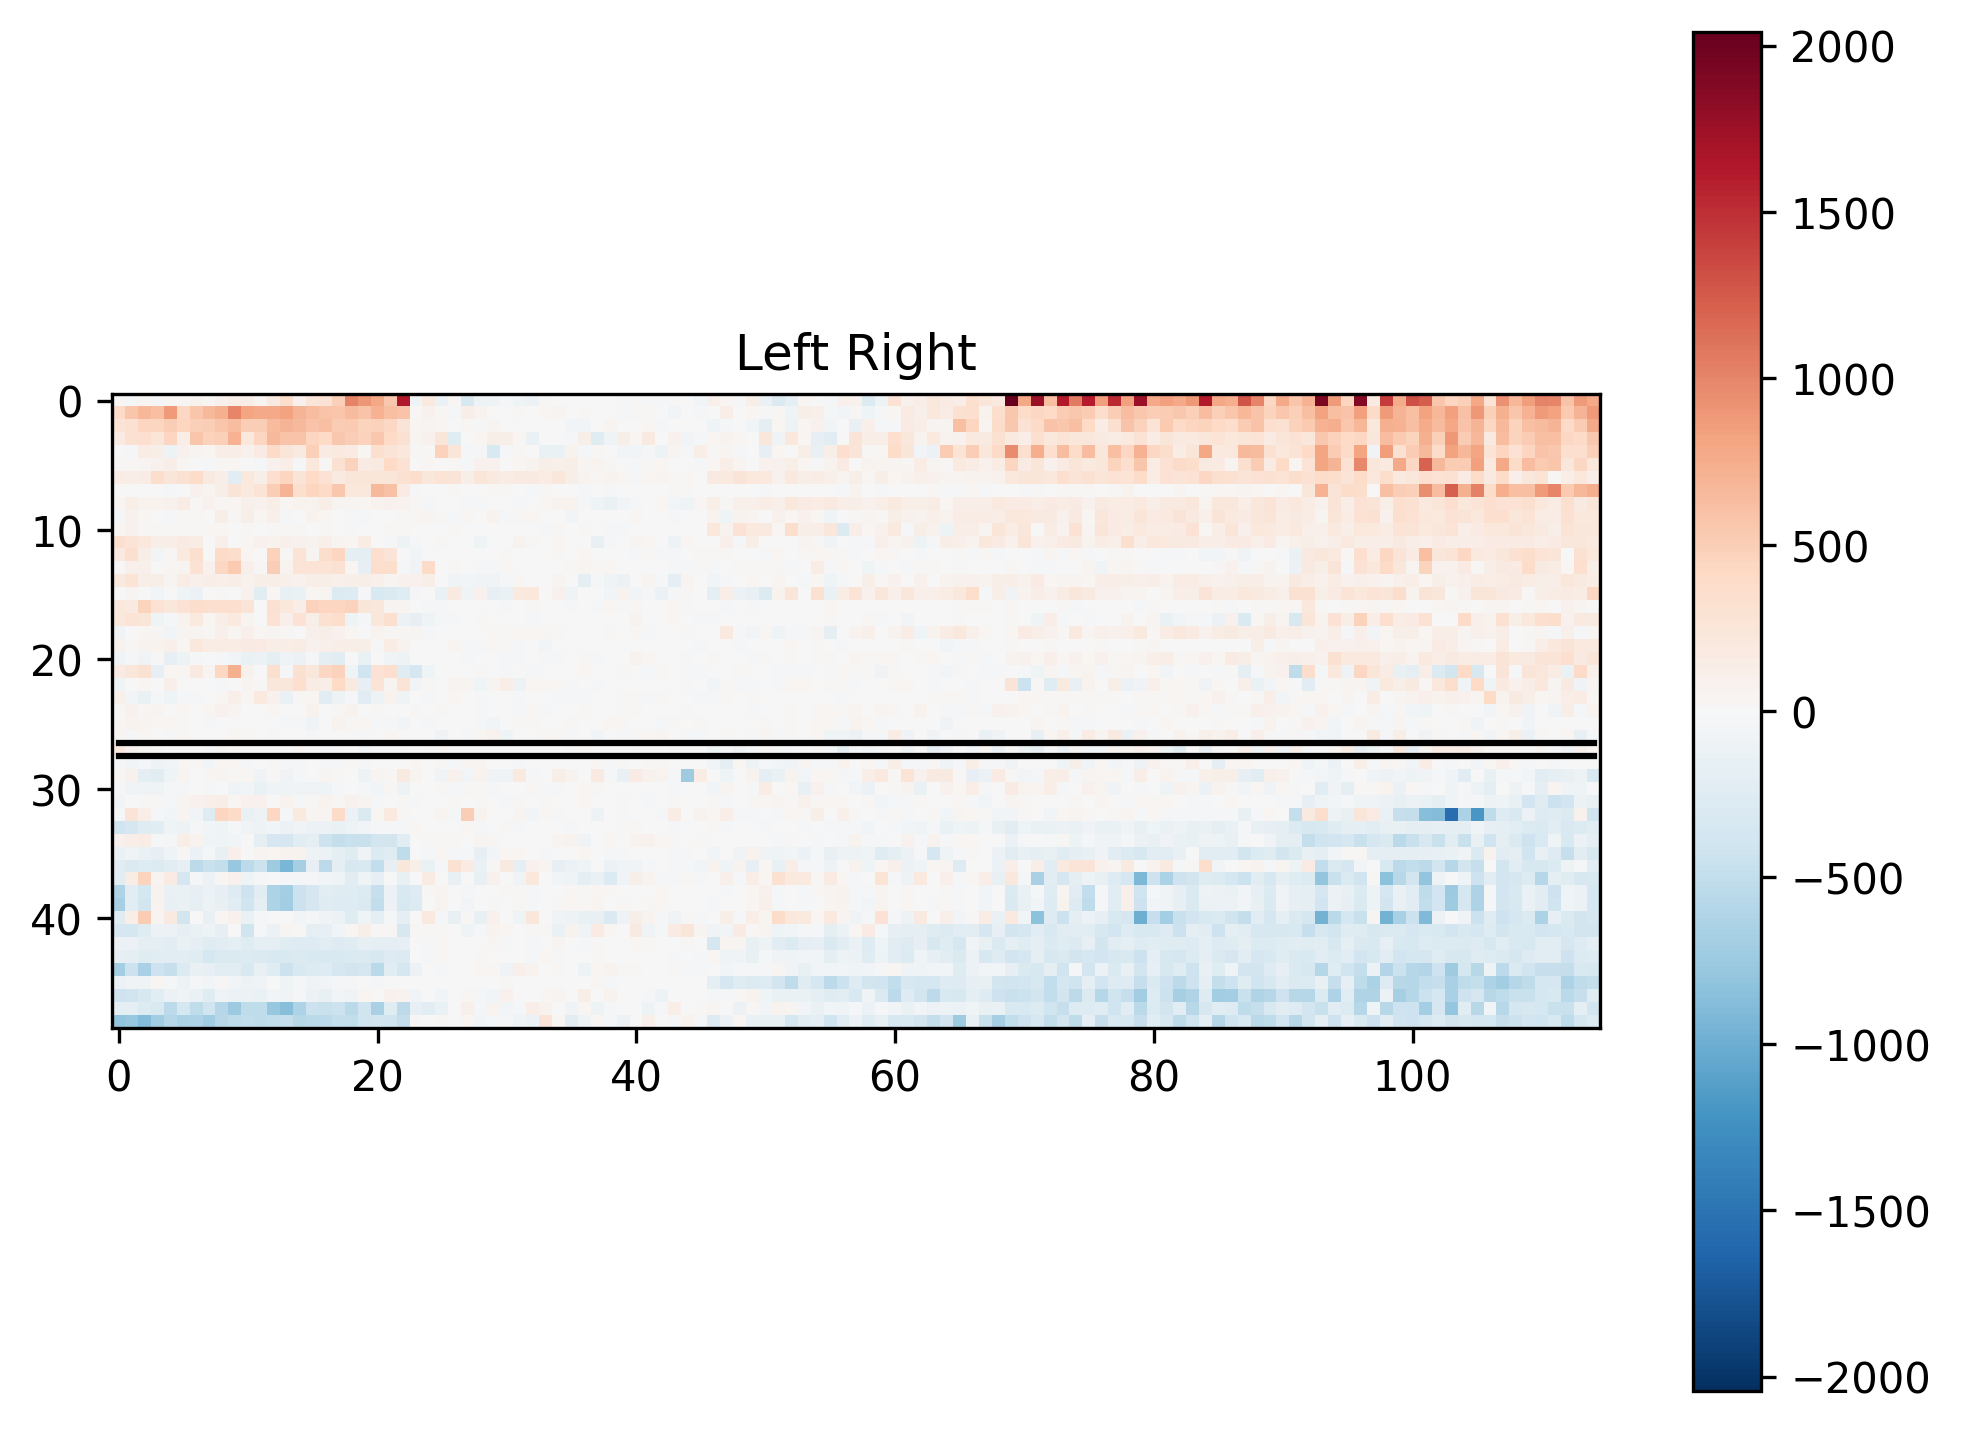

In [17]:
from sklearn.preprocessing import normalize
plt.figure(figsize=(8, 6), dpi=300)
cutoff = 115
Plotter = np.empty((cutoff,0))
for key in All_Manys_LR.keys():
    print(key)
    print(All_Manys_LR[key].shape)
    #print(np.sort(np.mean(All_Manys_LR[key][cutoff-24:cutoff,:],axis = 0)))
    if All_Manys_LR[key].shape[0]>=cutoff:
        Plotter = np.append(Plotter,All_Manys_LR[key][:cutoff,:],axis = 1)
    
#Plotter = normalize(Plotter, norm='max', axis=0)

data_temp = np.transpose(Plotter)
#data_temp = np.sign(data_temp)*np.log10(np.abs(data_temp))
#x =np.argsort(np.sum(data_temp[:,-24:],axis=1))
x =np.argsort(np.sum(data_temp[:,:],axis=1))
max_val_norm = max([np.max(data_temp),np.abs(np.min(data_temp))])
ax = plt.imshow(data_temp[np.flip(x),:],cmap = 'RdBu_r',vmin = -1*max_val_norm,vmax=max_val_norm)
#ax = plt.imshow(data_temp,cmap = 'RdBu_r',vmin = -1*max_val_norm,vmax=max_val_norm)
cutoffs = data_temp[np.flip(x),:]
topVal = sum(np.mean(cutoffs[:,-24:],axis=1)>0.25)-1.5
plt.plot([0,114],[topVal,topVal],'k')
bottomVal = cutoffs.shape[0]-sum(np.mean(cutoffs[:,-24:],axis=1)<-0.25)-0.5
plt.plot([0,114],[bottomVal,bottomVal],'k')

np.savetxt(BasePath_1+"Spot_LR.csv", data_temp[np.flip(x),:], delimiter=",")
plt.title("Left Right")
plt.savefig(BasePath_1+"Spot_LR.pdf",bbox_inches='tight')  
plt.colorbar()

Jan19_LargeLong
(138, 23)
Jan7
(92, 7)
Jan5
(115, 26)


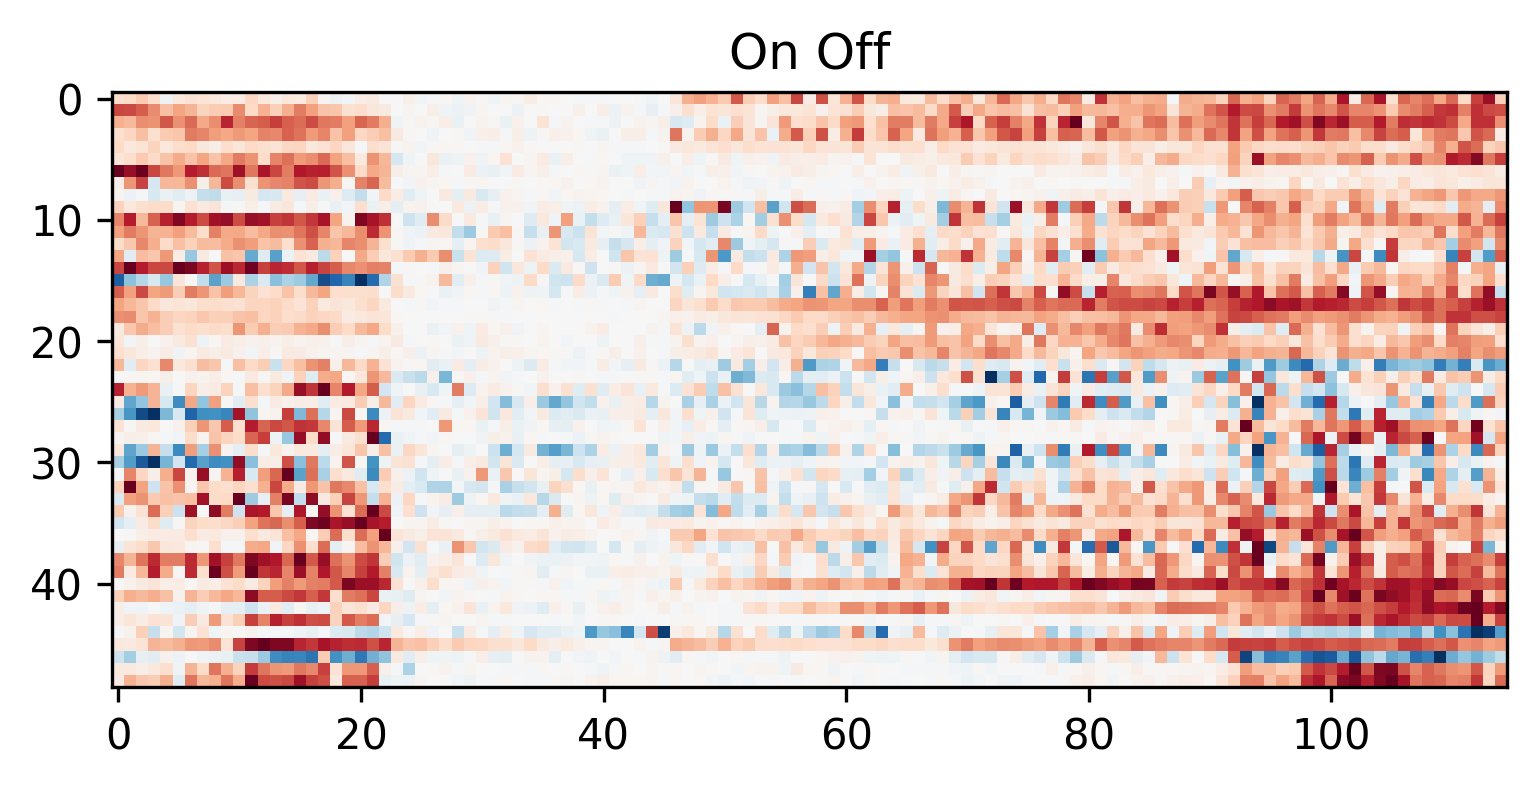

In [57]:
Plotter = np.empty((cutoff,0))
plt.figure(dpi = 300)
for key in All_Manys_OnOff.keys():
    print(key)
    print(All_Manys_OnOff[key].shape)
    if All_Manys_OnOff[key].shape[0]>=cutoff:
        Plotter = np.append(Plotter,All_Manys_OnOff[key][:cutoff,:],axis = 1)
data_temp = np.transpose(Plotter)
#data_temp = np.sign(data_temp)*np.log2(np.abs(data_temp))

#x =np.argsort(np.sum(data_temp[:,-24:],axis=1))
x =np.argsort(np.sum(data_temp[:,:],axis=1))
max_val_norm = max([np.max(data_temp),np.abs(np.min(data_temp))])
#ax = plt.imshow(data_temp[np.flip(x),:],cmap = 'RdBu_r',vmin = -1*max_val_norm,vmax=max_val_norm)
ax = plt.imshow(data_temp,cmap = 'RdBu_r',vmin = -1*max_val_norm,vmax=max_val_norm)
#ax = plt.imshow(data_temp[np.flip(x),:],cmap = 'RdBu_r')#,vmin = -1,vmax = 1)
np.savetxt(BasePath_1+"Spot_OnOff.csv", data_temp[np.flip(x),:], delimiter=",")
plt.title("On Off")
plt.savefig(BasePath_1+"Spot_OnOff.pdf",bbox_inches='tight')  

Jan19_LargeLong
(276, 23)
Jan7
(184, 7)
Jan5
(230, 26)


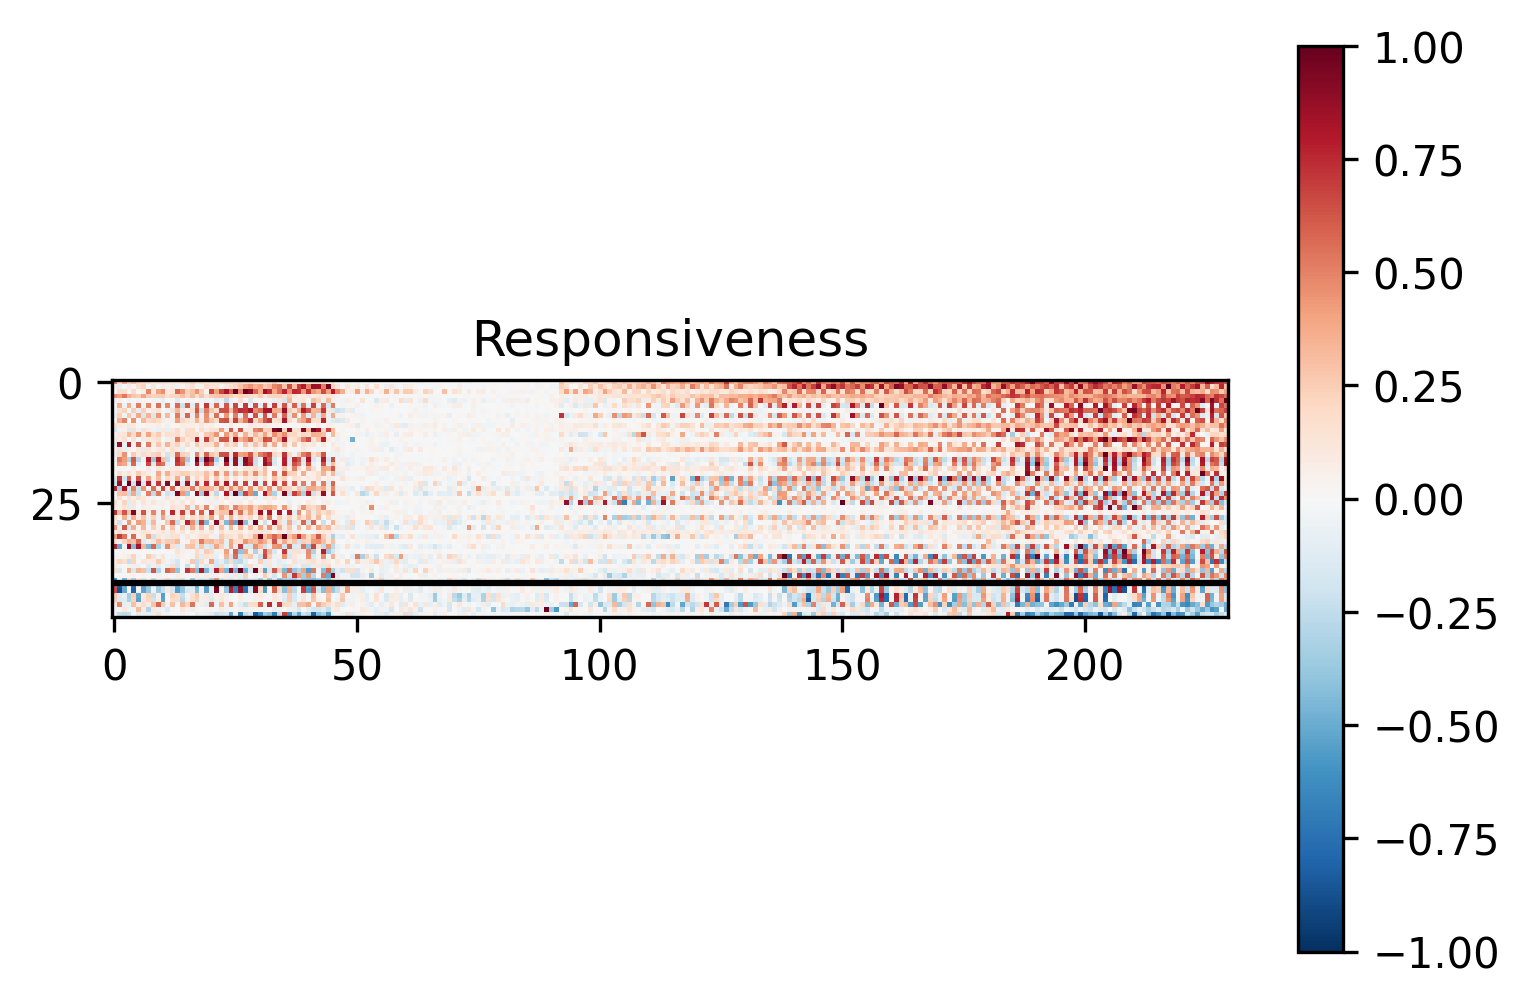

In [58]:
from sklearn.preprocessing import normalize
plt.figure(dpi=300)
cutoff = 230
Plotter = np.empty((cutoff,0))
for key in All_Many_Responsiveness.keys():
    print(key)
    print(All_Many_Responsiveness[key].shape)
    #print(np.sort(np.mean(All_Manys_LR[key][cutoff-24:cutoff,:],axis = 0)))
    if All_Many_Responsiveness[key].shape[0]>=cutoff:
        Plotter = np.append(Plotter,All_Many_Responsiveness[key][:cutoff,:],axis = 1)

if Normalize:
    Plotter[Plotter<0] =  Plotter[Plotter<0]*min_negative/max_positive
    
#Plotter = normalize(Plotter, norm='max', axis=0)

data_temp = np.transpose(Plotter)
#data_temp = np.sign(data_temp)*np.log10(np.abs(data_temp))
#x =np.argsort(np.sum(data_temp[:,-24:],axis=1))
x =np.argsort(np.sum(data_temp[:,:],axis=1))
max_val_norm = max([np.max(data_temp),np.abs(np.min(data_temp))])
ax = plt.imshow(data_temp[np.flip(x),:],cmap = 'RdBu_r',vmin = -1*max_val_norm,vmax=max_val_norm)#,vmin = -1,vmax = 1)
cutoffs = data_temp[np.flip(x),:]
topVal = sum(np.mean(cutoffs[:,-24:],axis=1)>0)-1.5
plt.plot([0,229],[topVal,topVal],'k')
np.savetxt(BasePath_1+"Spot_Responsiveness.csv", data_temp[np.flip(x),:], delimiter=",")
plt.title("Responsiveness")
plt.savefig(BasePath_1+"Spot_Responsiveness.pdf",bbox_inches='tight')  
plt.colorbar()

In [59]:
cutoffs = data_temp[np.flip(x),:]

(array([1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 2., 4., 1.,
        1., 3., 3., 4., 2., 4., 2., 1., 5., 2., 0., 0., 0., 1., 1., 1., 2.,
        0., 0., 1., 2., 0., 1.]),
 array([-3.67717372e-01, -3.41439452e-01, -3.15161531e-01, -2.88883611e-01,
        -2.62605691e-01, -2.36327770e-01, -2.10049850e-01, -1.83771930e-01,
        -1.57494010e-01, -1.31216089e-01, -1.04938169e-01, -7.86602486e-02,
        -5.23823283e-02, -2.61044080e-02,  1.73512304e-04,  2.64514326e-02,
         5.27293529e-02,  7.90072732e-02,  1.05285194e-01,  1.31563114e-01,
         1.57841034e-01,  1.84118954e-01,  2.10396875e-01,  2.36674795e-01,
         2.62952715e-01,  2.89230636e-01,  3.15508556e-01,  3.41786476e-01,
         3.68064397e-01,  3.94342317e-01,  4.20620237e-01,  4.46898158e-01,
         4.73176078e-01,  4.99453998e-01,  5.25731918e-01,  5.52009839e-01,
         5.78287759e-01,  6.04565679e-01,  6.30843600e-01,  6.57121520e-01,
         6.83399440e-01]),
 <BarContainer object of 40

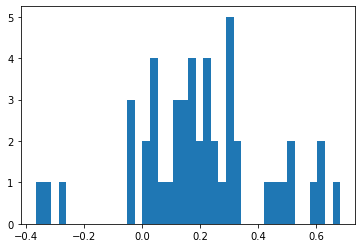

In [60]:
plt.hist(np.mean(data_temp[:,-24:],axis=1),bins = 40)

## Lifetime Tricaine

In [78]:
dfOverF = False
Normalize = False

In [46]:
from scipy.interpolate import interp1d

BasePath_1 =  DropboxPath+ "Lifetime_Tricaine/"

All_Manys_OnOff = {}
All_Manys_LR = {}
All_Many_Responsiveness = {}

max_positive = 0
min_negative = 0

for Fish in [d for d in os.listdir(BasePath_1) if os.path.isdir(BasePath_1+d)]:
    BasePath = BasePath_1 + Fish + '/'
    files = [i for i in os.listdir(BasePath) if "2022" in i]
    files.sort()
    Manys_LR = np.empty((len(files)*24,0))
    Manys_OnOff = np.empty((len(files)*24,0))
    Many_Responsiveness = np.empty((len(files)*48,0))
    
    for locNames in ['LR_measurements.csv','OnOff_measurements.csv']:
        fileLoc = BasePath + "Sept/"+locNames
        df = pd.read_csv(fileLoc)

        regs = {}

        for regional_traces in range(1,int((len(df.columns)-1)/4)):
            s = list(df['Mean'+str(regional_traces)])
            vals_left = []
            vals_right = []
            vals_responsive = []
            #plt.figure()
            for i,file in enumerate(files):
                vals_left_mean = np.empty((160,0))
                vals_right_mean = np.empty((160,0))
                #plt.subplot(len(files),1,i+1)
                visual_stimulus_data = np.load(BasePath + file + '/rawdata/z_plane0000_trial000_stimulus_data.npz')
                r = np.load(BasePath + file + '/rawdata/z_plane0000_trial000_imaging_information.npy')
                imaging_time = r[:,0]
                f_imaging_interpolation_function_C = interp1d(imaging_time, s[i*2936:(i+1)*2936], bounds_error=False)
                for stimulus_start_time, stim in zip(visual_stimulus_data["stimulus_start_times"][1:],
                                                        visual_stimulus_data["stimulus_start_indices"][1:]):
                    # create a new time array that is 80 seconds and separated at 0.5 sec. i.e. 2 Hz sampling rate
                    # -> Armin did this to scale all imaging data to 2Hz sampling rate...
                    ts = np.arange(stimulus_start_time -10, stimulus_start_time +70 - 0.25, 0.5) # -0.25 is to get exactly 160 samples

                    stimulus_aligned_C = f_imaging_interpolation_function_C(ts)  ## !
                    if dfOverF is True:
                        regions = np.expand_dims((stimulus_aligned_C-np.mean(stimulus_aligned_C[:40]))/np.mean(stimulus_aligned_C[:40]),1)
                    else:
                        regions = np.expand_dims(stimulus_aligned_C-np.mean(stimulus_aligned_C[:40]),1)
                    if (stim == 0) & (vals_left_mean.shape[1] < 24):
                        vals_left_mean = np.append(vals_left_mean,regions,axis = 1)
                        vals_responsive.append(np.mean(regions[40:100]))
                        vals_left.append(np.mean(regions[40:100]))
                    elif (stim == 1) & (vals_right_mean.shape[1] < 24):
                        vals_right_mean = np.append(vals_right_mean,regions,axis = 1)
                        vals_responsive.append(np.mean(regions[40:100]))
                        vals_right.append(np.mean(regions[40:100]))

            #regs['Mean'+str(regional_traces)] = np.array(vals_right)-np.array(vals_left)
            to_append = np.array(vals_right)-np.array(vals_left)
            if Normalize:
                max_positive = max(max_positive,max(vals_responsive))
                min_negative = max(min_negative,abs(min(vals_responsive)))
                Manys_LR = np.append(Manys_LR,np.expand_dims(to_append/np.max(np.abs(to_append)),axis=1),axis = 1)
                Many_Responsiveness = np.append(Many_Responsiveness,np.expand_dims(vals_responsive/np.max(np.abs(vals_responsive)),axis=1),axis = 1)
                to_append = np.array(vals_right)+np.array(vals_left)
                Manys_OnOff = np.append(Manys_OnOff,np.expand_dims(to_append/np.max(np.abs(to_append)),axis=1),axis = 1)
            else:
                Manys_LR = np.append(Manys_LR,np.expand_dims(to_append,axis=1),axis=1)#
                to_append = np.array(vals_right)+np.array(vals_left)
                Many_Responsiveness = np.append(Many_Responsiveness,np.expand_dims(vals_responsive,axis=1),axis=1)
                Manys_OnOff = np.append(Manys_OnOff,np.expand_dims(to_append,axis=1),axis=1)#
            # Place this code: ',axis=1),axis=1)#' in after "to_append" to get rid of normalization.
    All_Manys_OnOff[Fish] = Manys_OnOff
    All_Manys_LR[Fish] = Manys_LR
    All_Many_Responsiveness[Fish] = Many_Responsiveness

Feb15
(96, 21)
Feb16
(120, 24)
Feb17_LargeLong
(96, 33)


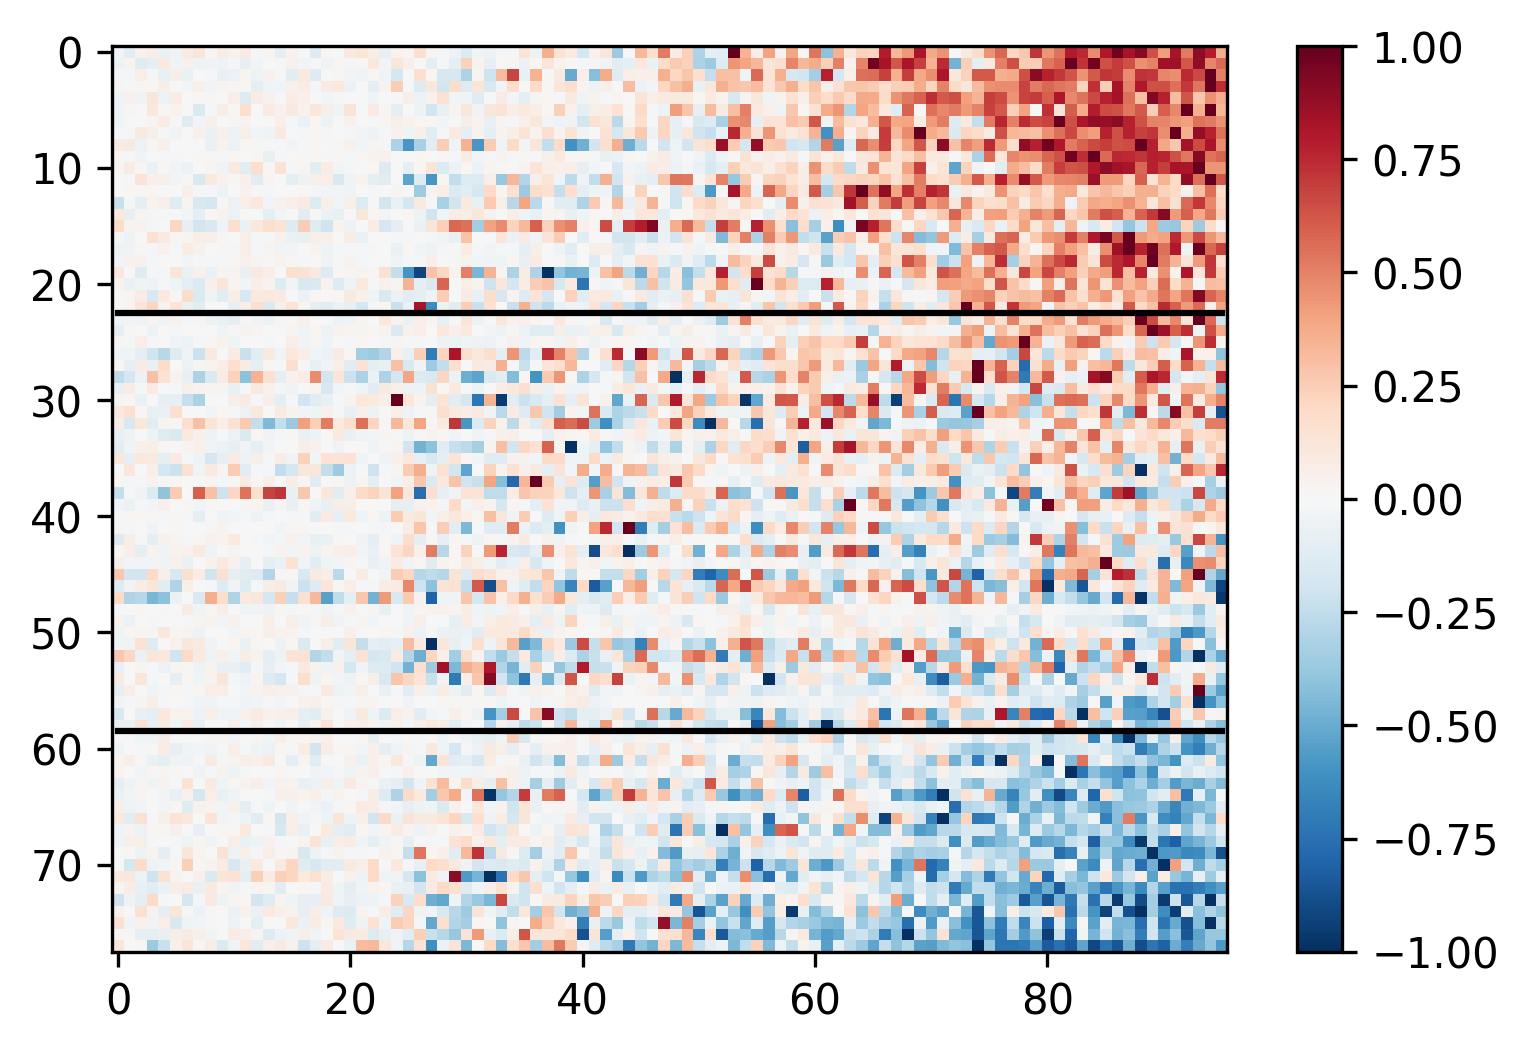

In [47]:
cutoff = 96
plt.figure(dpi=300)
Plotter = np.empty((cutoff,0))
for key in All_Manys_LR.keys():
    print(key)
    print(All_Manys_LR[key].shape)
    if All_Manys_LR[key].shape[0]>=cutoff:
        Plotter = np.append(Plotter,All_Manys_LR[key][:cutoff,:],axis = 1)
data_temp = np.transpose(Plotter)
#x =np.argsort(np.sum(data_temp[:,-24:],axis=1))
x =np.argsort(np.sum(data_temp[:,:],axis=1))
max_val_norm = max([np.max(data_temp),np.abs(np.min(data_temp))])
ax = plt.imshow(data_temp[np.flip(x),:],cmap = 'RdBu_r',vmin = -1*max_val_norm,vmax=max_val_norm)
cutoffs = data_temp[np.flip(x),:]
topVal = sum(np.mean(cutoffs[:,-24:],axis=1)>0.25)-1.5
plt.plot([0,cutoff-1],[topVal,topVal],'k')
bottomVal = cutoffs.shape[0]-sum(np.mean(cutoffs[:,-24:],axis=1)<-0.25)-0.5
plt.plot([0,cutoff-1],[bottomVal,bottomVal],'k')
#ax = plt.imshow(data_temp[np.flip(x),:],cmap = 'RdBu_r')#,vmin = -1,vmax = 1)
np.savetxt(BasePath_1+"Lifetime_LR.csv", data_temp[np.flip(x),:], delimiter=",")
plt.savefig(BasePath_1+"Lifetime_LR.pdf",bbox_inches='tight')  
plt.colorbar()

Feb15
(96, 21)
Feb16
(120, 24)
Feb17_LargeLong
(96, 33)


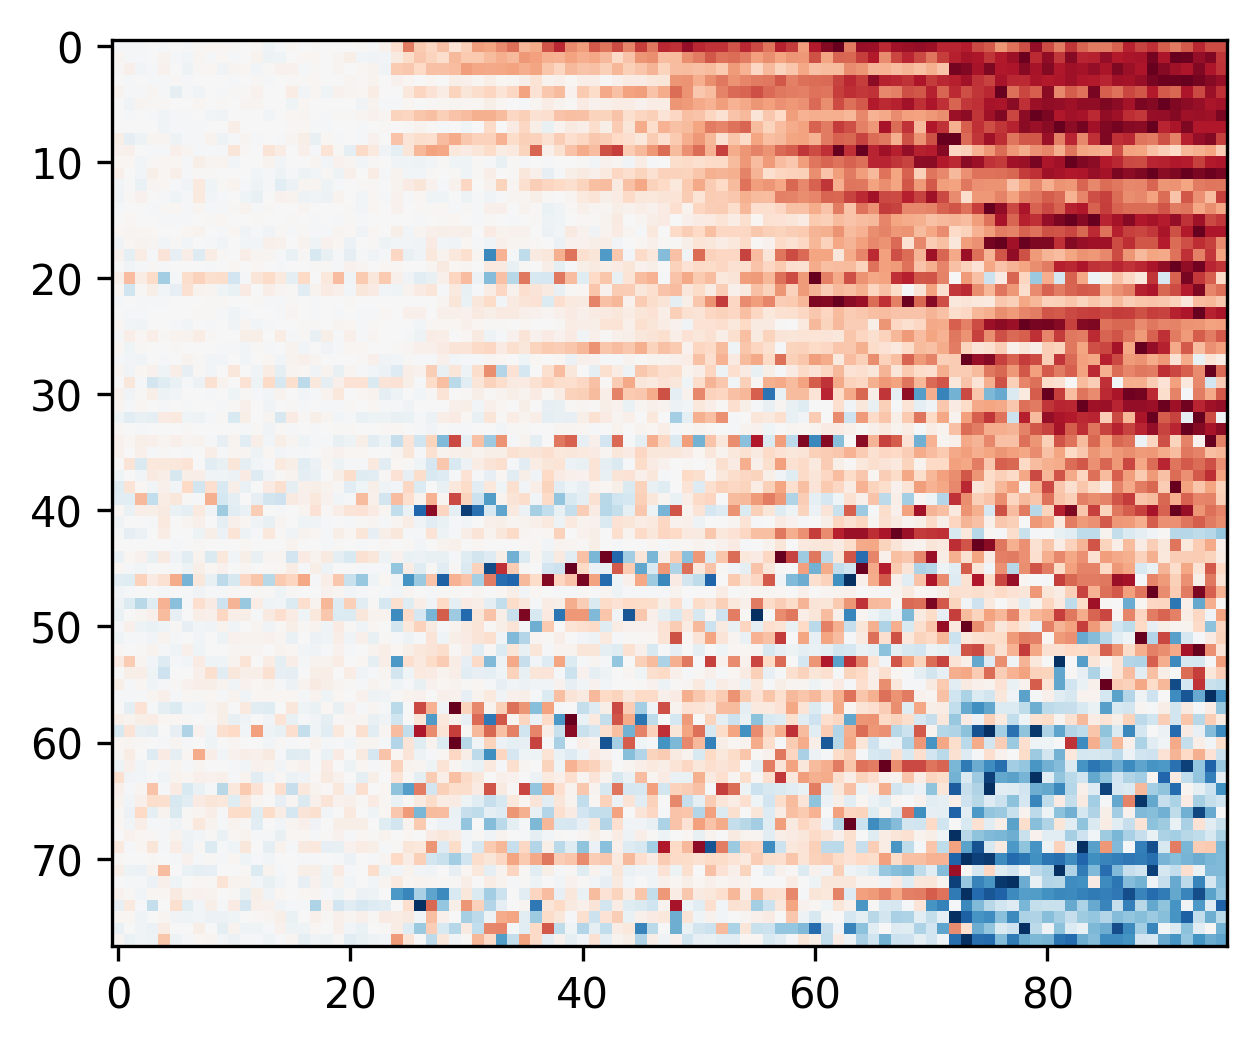

In [48]:
plt.figure(dpi = 300)
Plotter = np.empty((cutoff,0))
for key in All_Manys_OnOff.keys():
    print(key)
    print(All_Manys_OnOff[key].shape)
    if All_Manys_OnOff[key].shape[0]>=cutoff:
        Plotter = np.append(Plotter,All_Manys_OnOff[key][:cutoff,:],axis = 1)
data_temp = np.transpose(Plotter)
#x =np.argsort(np.sum(data_temp[:,-24:],axis=1))
x =np.argsort(np.sum(data_temp[:,:],axis=1))
max_val_norm = max([np.max(data_temp),np.abs(np.min(data_temp))])
ax = plt.imshow(data_temp[np.flip(x),:],cmap = 'RdBu_r',vmin = -1*max_val_norm,vmax=max_val_norm)#,vmin = -1,vmax = 1)
#ax = plt.imshow(data_temp[np.flip(x),:],cmap = 'RdBu_r')#,vmin = -1,vmax = 1)
np.savetxt(BasePath_1+"Lifetime_OnOff.csv", data_temp[np.flip(x),:], delimiter=",")
plt.savefig(BasePath_1+"Lifetime_OnOff.pdf",bbox_inches='tight')  

Feb15
(192, 21)
Feb16
(240, 24)
Feb17_LargeLong
(192, 33)


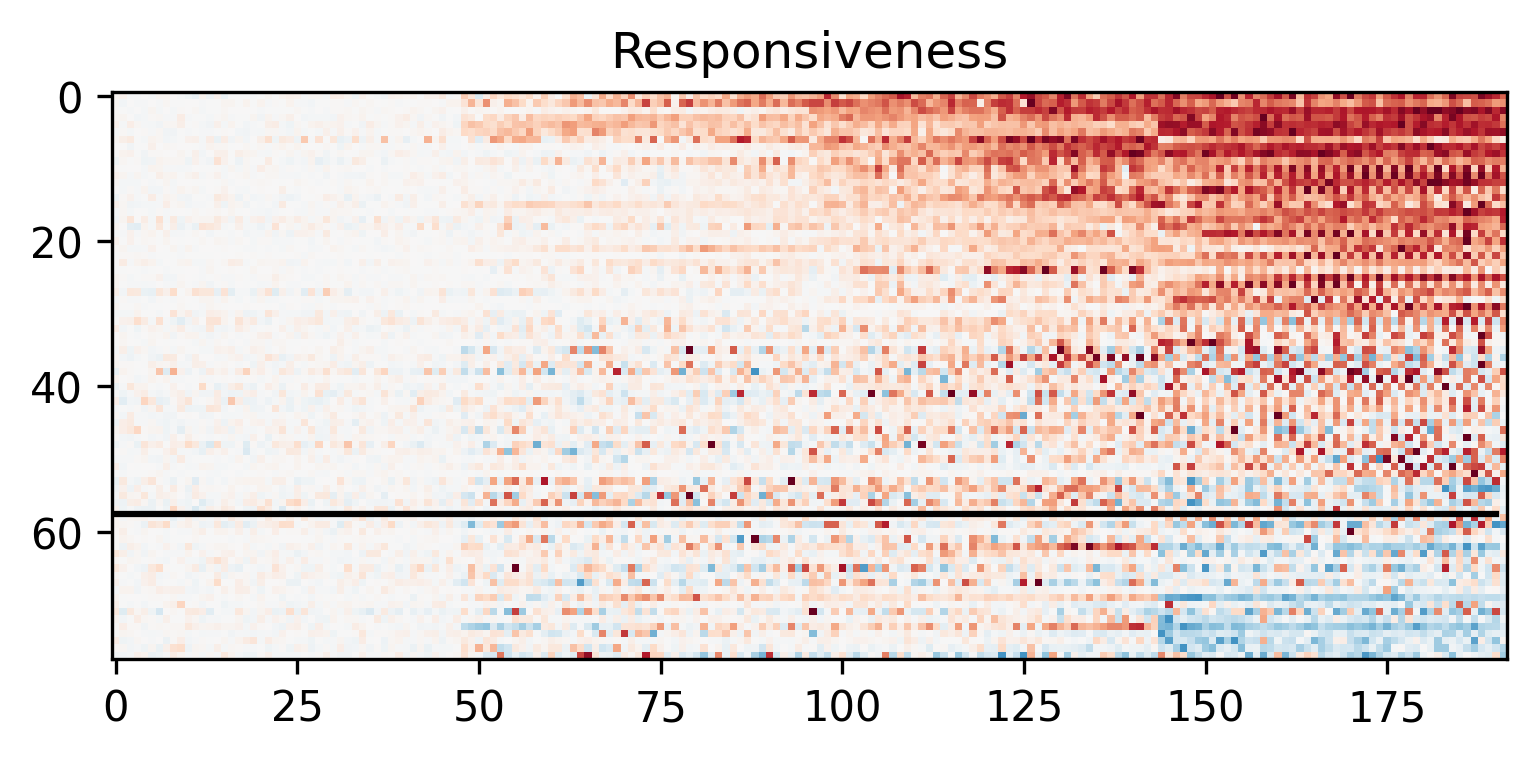

In [50]:
from sklearn.preprocessing import normalize
plt.figure(dpi = 300)
cutoff = 192
Plotter = np.empty((cutoff,0))
for key in All_Many_Responsiveness.keys():
    print(key)
    print(All_Many_Responsiveness[key].shape)
    #print(np.sort(np.mean(All_Manys_LR[key][cutoff-24:cutoff,:],axis = 0)))
    if All_Many_Responsiveness[key].shape[0]>=cutoff:
        Plotter = np.append(Plotter,All_Many_Responsiveness[key][:cutoff,:],axis = 1)
    
#Plotter = normalize(Plotter, norm='max', axis=0)
if Normalize:
    Plotter[Plotter<0] =  Plotter[Plotter<0]*min_negative/max_positive

data_temp = np.transpose(Plotter)
#data_temp = np.sign(data_temp)*np.log10(np.abs(data_temp))
#x =np.argsort(np.sum(data_temp[:,-24:],axis=1))
x =np.argsort(np.sum(data_temp[:,:],axis=1))
max_val_norm = max([np.max(data_temp),np.abs(np.min(data_temp))])
ax = plt.imshow(data_temp[np.flip(x),:],cmap = 'RdBu_r',vmin = -1*max_val_norm,vmax=max_val_norm)#,vmin = -1,vmax = 1)
cutoffs = data_temp[np.flip(x),:]
topVal = sum(np.mean(cutoffs[:,-24:],axis=1)>0)-1.5
plt.plot([0,192-2],[topVal,topVal],'k')
np.savetxt(BasePath_1+"Lifetime_Responsiveness.csv", data_temp[np.flip(x),:], delimiter=",")
plt.title("Responsiveness")
plt.savefig(BasePath_1+"Lifetime_Responsiveness.pdf",bbox_inches='tight')  
#plt.colorbar()

# old lifetime tricaine loader

In [ ]:
from scipy.interpolate import interp1d

BasePath_1 =  DropboxPath+ "Lifetime_Tricaine/"
All_Manys_OnOff = {}
All_Manys_LR = {}
for Fish in [d for d in os.listdir(BasePath_1) if os.path.isdir(BasePath_1+d)]:
    #Fish = 'Feb17_LargeLong'
    BasePath = BasePath_1 + Fish + '/'
    files = [i for i in os.listdir(BasePath) if "2022" in i]
    files.sort()
    Manys_LR = np.empty((len(files)*24,0))
    Manys_OnOff = np.empty((len(files)*24,0))
    
    for locNames in ['LR_measurements.csv','OnOff_measurements.csv']:
        fileLoc = BasePath + locNames
        df = pd.read_csv(fileLoc)

        regs = {}

        for regional_traces in range(1,int((len(df.columns)-1)/4)):
            s = list(df['Mean'+str(regional_traces)])
            vals_left = []
            vals_right = []
            #plt.figure()
            for i,file in enumerate(files):
                vals_left_mean = np.empty((160,0))
                vals_right_mean = np.empty((160,0))
                #plt.subplot(len(files),1,i+1)
                visual_stimulus_data = np.load(BasePath + file + '/rawdata/z_plane0000_trial000_stimulus_data.npz')
                r = np.load(BasePath + file + '/rawdata/z_plane0000_trial000_imaging_information.npy')
                imaging_time = r[:,0]
                f_imaging_interpolation_function_C = interp1d(imaging_time, s[i*2936:(i+1)*2936], bounds_error=False)
                for stimulus_start_time, stim in zip(visual_stimulus_data["stimulus_start_times"][1:],
                                                        visual_stimulus_data["stimulus_start_indices"][1:]):
                    # create a new time array that is 80 seconds and separated at 0.5 sec. i.e. 2 Hz sampling rate
                    # -> Armin did this to scale all imaging data to 2Hz sampling rate...
                    ts = np.arange(stimulus_start_time -10, stimulus_start_time +70 - 0.25, 0.5) # -0.25 is to get exactly 160 samples

                    stimulus_aligned_C = f_imaging_interpolation_function_C(ts)  ## !
                    regions = np.expand_dims(stimulus_aligned_C-np.mean(stimulus_aligned_C[:40]),1)
                    if (stim == 0) & (vals_left_mean.shape[1] < 24):
                        vals_left_mean = np.append(vals_left_mean,regions,axis = 1)
                        vals_left.append(np.mean(regions[40:100]))
                    elif (stim == 1) & (vals_right_mean.shape[1] < 24):
                        vals_right_mean = np.append(vals_right_mean,regions,axis = 1)
                        vals_right.append(np.mean(regions[40:100]))
                #plt.plot(np.mean(vals_left_mean,axis = 1))
                #plt.plot(np.mean(vals_right_mean,axis = 1))
            regs['Mean'+str(regional_traces)] = np.array(vals_right)-np.array(vals_left)
            to_append = np.array(vals_right)-np.array(vals_left)
            Manys_LR = np.append(Manys_LR,np.expand_dims(to_append/np.max(np.abs(to_append)),axis=1),axis = 1)
            to_append = np.array(vals_right)+np.array(vals_left)
            Manys_OnOff = np.append(Manys_OnOff,np.expand_dims(to_append/np.max(np.abs(to_append)),axis=1),axis = 1) 
            # Place this code: ',axis=1),axis=1)#' in after "to_append" to get rid of normalization.
    All_Manys_OnOff[Fish] = Manys_OnOff
    All_Manys_LR[Fish] = Manys_LR